In [1]:
import numpy as np
import glob
from scipy.optimize import curve_fit
import h5py
from natsort import natsorted
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [2]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import sys
sys.path.insert(0,'../../')
sys.path.insert(0,'../../WaveformAnalysis')

In [4]:
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
import Dataset as Dataset
import Waveform as Waveform
import SiPM as SiPM

In [6]:
import importlib
importlib.reload(Dataset)
importlib.reload(SiPM)
importlib.reload(Waveform)

<module 'Waveform' from '../../WaveformAnalysis\\Waveform.py'>

In [38]:
Path = r'C:\\Data\\202206[0-1][9,1,2,3,0]\\'

Let's get the voltage steps from the filenames

In [34]:
voltages = glob.glob(Path+'wave*')
voltages = [x.split('_')[-2] for x in voltages]
voltages = np.array(sorted([x.split('OV')[0] for x in voltages]))
voltages = np.unique(voltages)
print(voltages)

['2.00' '2.50' '3.00' '3.50' '4.00' '4.50' '5.00' '5.50' '6.00' '6.50'
 '7.00']


Now we can loop over all files for the various voltages, save the data and run a simple analysis including baseline subtraction and maximum finding

In [58]:
def rebin(hx,h,bins):
    h_rebin=[]
    for i in range(int(len(h)/bins)):
        start_idx=i*bins
        end_idx=(i+1)*bins
        h_rebin.append(np.sum(h[start_idx:end_idx]))
    hx_rebin=range(len(h_rebin))
    return np.array(hx_rebin), np.array(h_rebin)

def rebin_2(hx,h,start, stop, step):
    rebinned = {}
    bins = np.arange(start,stop+step, step)
    for i, interval in enumerate(bins[:-1]):
        if not f'{bins[i]}-{bins[i+1]}' in rebinned.keys(): rebinned[f'{bins[i]}-{bins[i+1]}'] = 0
    print(rebinned)
    for val in hx:
        index = int(val/step)
        rebinned[rebinned.keys()]
    return
    h_rebin=[]
    for i in range(int(len(h)/bins)):
        start_idx=i*bins
        end_idx=(i+1)*bins
        h_rebin.append(np.sum(h[start_idx:end_idx]))
    hx_rebin=range(len(h_rebin))
    return np.array(hx_rebin), np.array(h_rebin)
rebin_2(0,0,0,100,10)

{'0-10': 0, '10-20': 0, '20-30': 0, '30-40': 0, '40-50': 0, '50-60': 0, '60-70': 0, '70-80': 0, '80-90': 0, '90-100': 0}


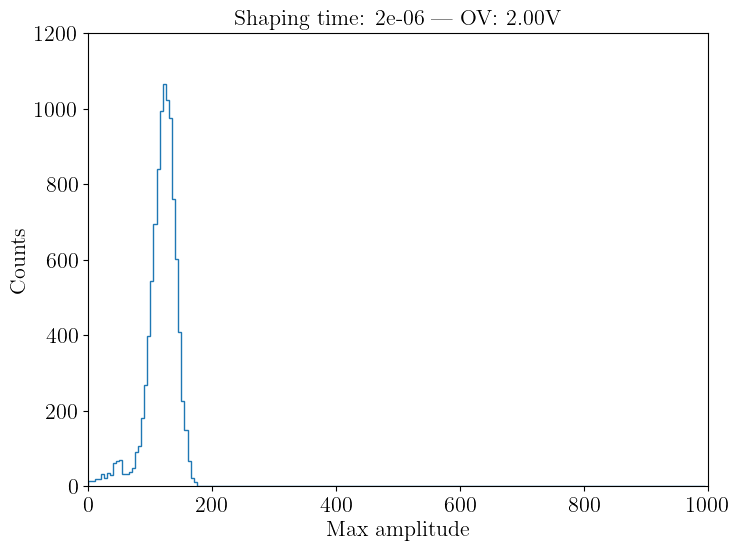

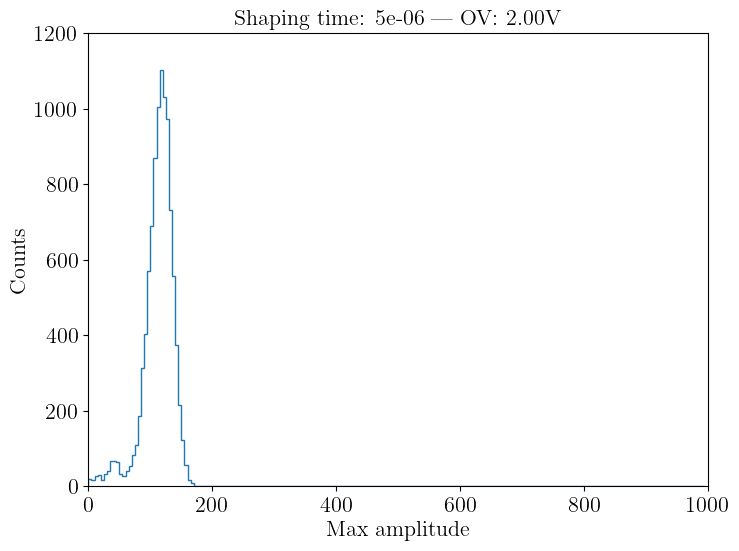

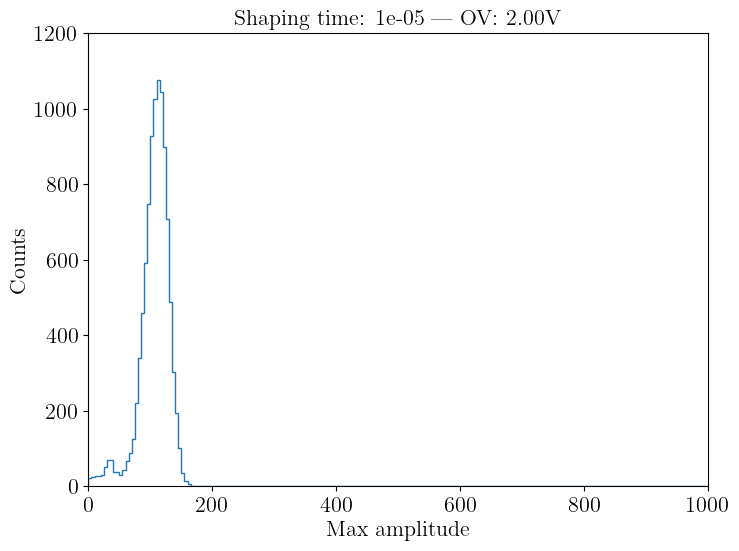

10000 waveforms in total (unfiltered) from 500 files


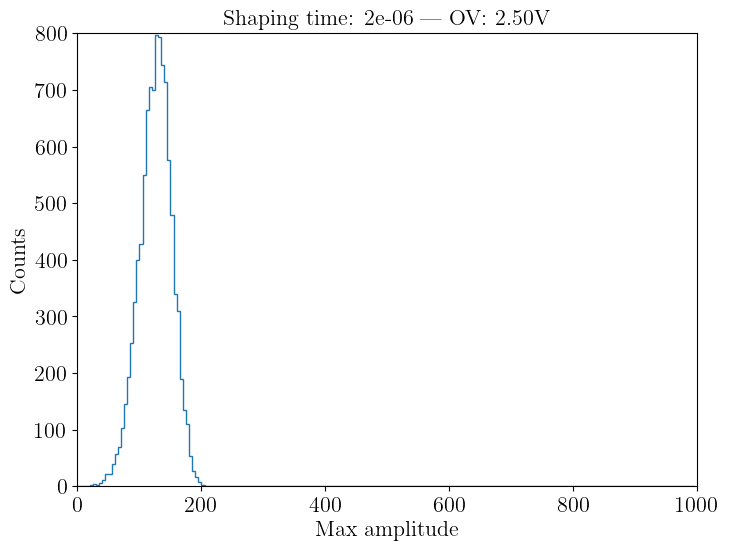

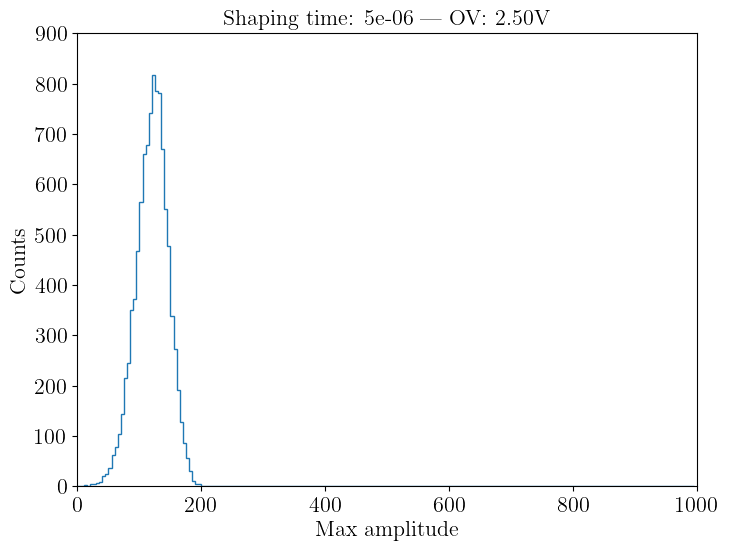

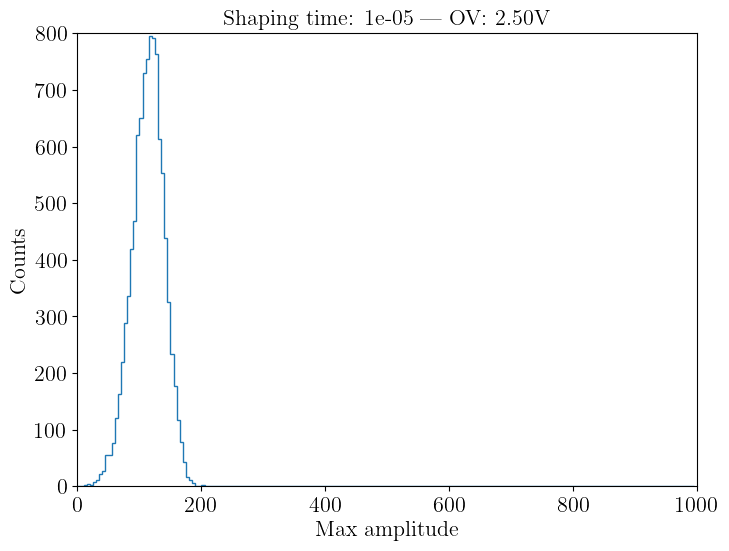

10000 waveforms in total (unfiltered) from 500 files


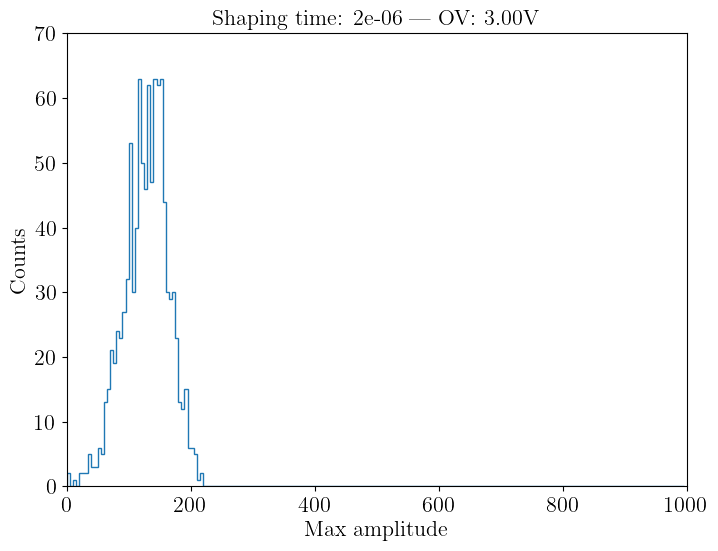

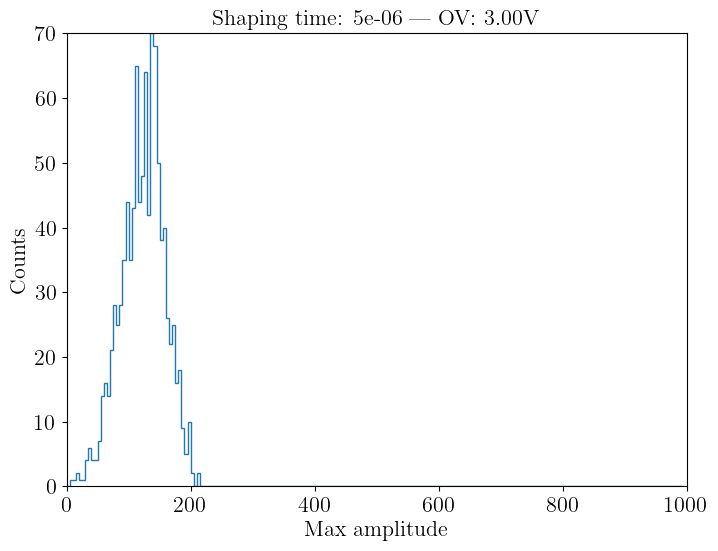

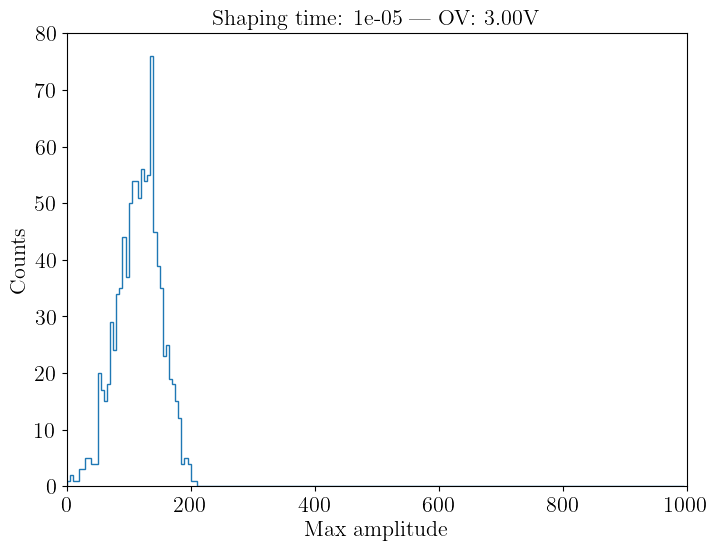

1000 waveforms in total (unfiltered) from 50 files


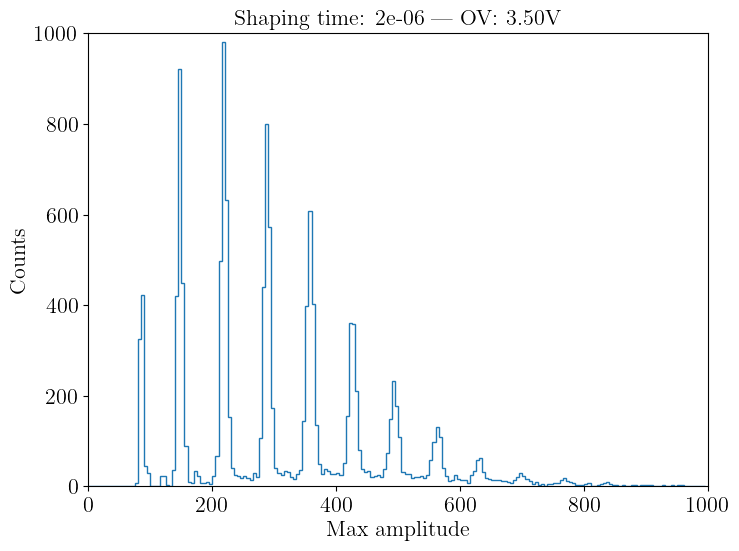

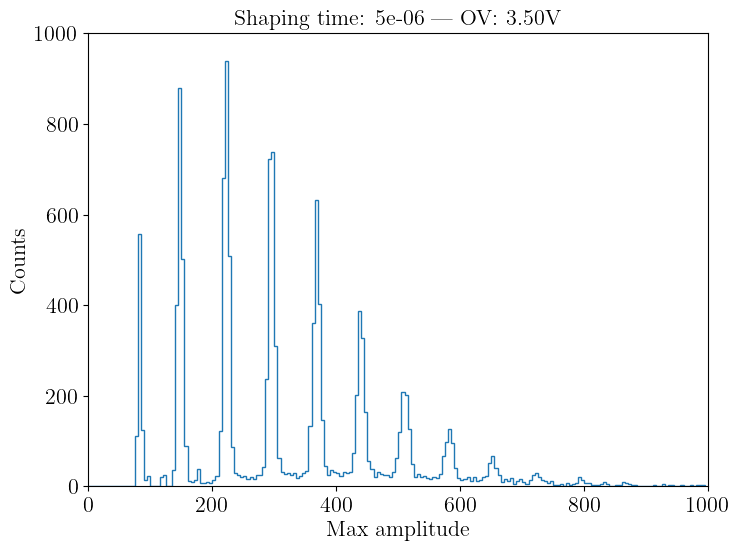

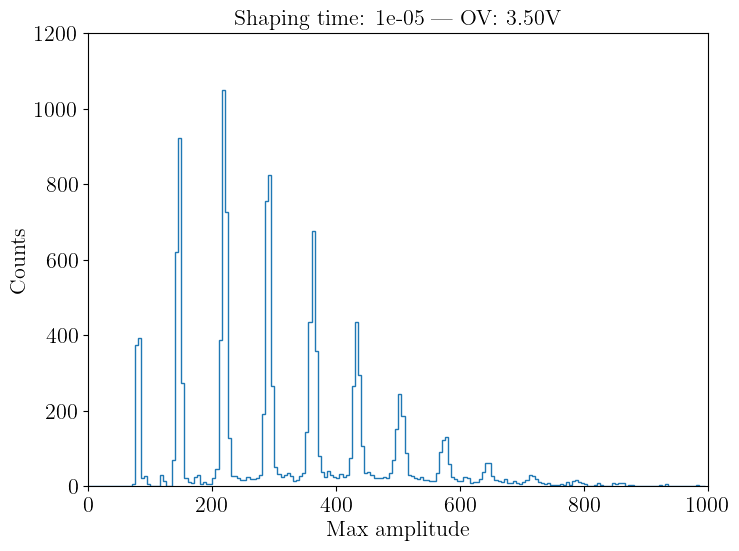

13400 waveforms in total (unfiltered) from 540 files


In [60]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

Ds = {}
N_peaks= 4
for volt in voltages: 
    Ds[volt] = SiPM.SiPM(Path=Path, Selection='wavefms_keith_{}OV*.h5'.format(volt))
    Ds[volt].Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]
    
    peak_amps = {} #dict of shaping time as key and peak values for waveforms filtered with that shaping time
    peak_occs = {} #same thing but counting the occurrences so it will be a dict of dicts for each shaping time and peak
    all_v = []

    total = 0
    files = 0


    #The code below just loads the data from the files into the SiPM instance Ds[volt]
    for File in natsorted(Ds[volt].Files):
        # print(f'{total} waveforms in total (unfiltered) from {files} files')
        max_amp_all_st=[]
        files += 1
        Ds[volt].ImportDataFromHDF5(File, Ds[volt].Ch, var=[])
        Ds[volt].get_sampling()
        Ds[volt].shaping_time=[2e-6,5e-6,10e-6] #List of shaping times to shape the signal with
        Ds[volt].setup_butter_filter() # calculate the butterworth filter coefficients

    for waveform in Ds[volt].Ch[0].Amp: #loop over the waveforms inside the file
    # print(waveform)
        total += 1

        y = Ds[volt].get_filtered_waveform(waveform) # return the filtered waveform
        # y = [waveform]
        # plt.plot(Ds[volt].Ch[0].Time,waveform,color='k',label='data')
        # plt.figure()


        # max_amp,max_T=Ds[volt].Ch[0].GetAllMaxima(y)
        # max_amp_all_st.append(max_amp)
        # plt.plot(max_T,max_amp,'r*')  
        
        for i,y1 in enumerate(y): #Iterates each wave filtered with a different shaping time
            p_ind = np.argmax(y1) #Finds the index for max value in the waveform amplitude array
            p_val = y1[p_ind] #Gets the max value from the array of amps
     

            if not Ds[volt].shaping_time[i] in peak_amps.keys(): peak_amps[Ds[volt].shaping_time[i]] = [] #
            if not Ds[volt].shaping_time[i] in peak_occs.keys(): peak_occs[Ds[volt].shaping_time[i]] = {}

            peak_amps[Ds[volt].shaping_time[i]].append(p_val)

            if not p_val in peak_occs[Ds[volt].shaping_time[i]].keys(): peak_occs[Ds[volt].shaping_time[i]][p_val] = 1
            else: peak_occs[Ds[volt].shaping_time[i]][p_val] += 1
            all_v.append(p_val)

            # plt.plot(Ds[volt].Ch[0].Time[np.argmax(y1)],y1[np.argmax(y1)],'r+')
            # plt.plot(Ds[volt].Ch[0].Time,y1,color=colors[i])
            # plt.xlim(180,300)
            # plt.xlabel('Time')
            # plt.ylabel('Amplitude')
    # plt.show()
        # plt.xlim(180,225)

    # pp.pprint(peak_amps)

    x_vals = []
    y_vals = []

    for sh_time in peak_amps.keys():

        for peak in np.sort(np.fromiter(peak_occs[sh_time].keys(), dtype=float)):
            counts = peak_occs[sh_time][peak]
            x_vals.append(peak)
            y_vals.append(counts)

        plt.figure()
        # hx, h = rebin(x_vals,y_vals,100)
        # plt.plot(hx,h,color='k',label='data')
        plt.hist(peak_amps[sh_time],bins=np.arange(0,1000,5),histtype='step')
        x, y = np.histogram(peak_amps[sh_time],bins=np.arange(0,1000,5))
        # plt.ylim(0,12)
        # plt.xlim(0,800)
        plt.xlabel('Max amplitude')
        plt.ylabel('Counts')
        # plt.yscale('log')
        plt.title(f"Shaping time: {sh_time} | OV: {volt}V")
        plt.show()
        x_vals = []
        y_vals = []

    print(f'{total} waveforms in total (unfiltered) from {files} files')


In [30]:
def line(x,a,b):
    return a*x+b

KeyError: '3.50'

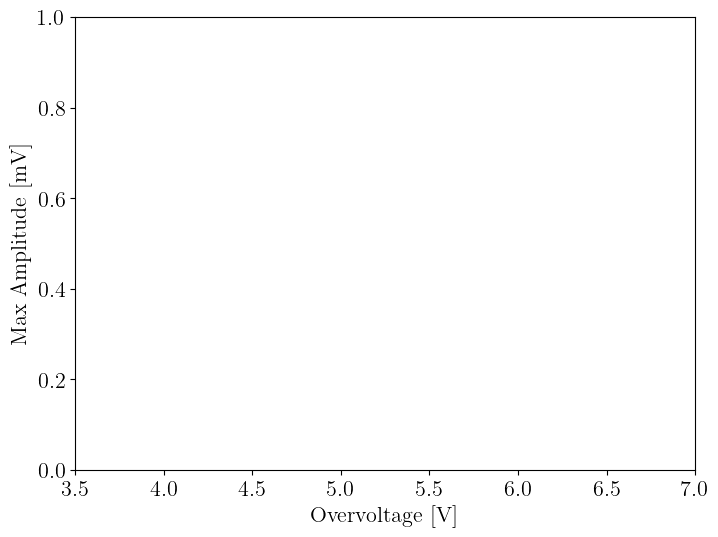

In [18]:
plt.figure()
plt.xlim(np.min(voltages.astype(float)), np.max(voltages.astype(float)))
plt.xlabel('Overvoltage [V]')
plt.ylabel('Max Amplitude [mV]')

ys = {}
ys[0] = []
ys[1] = []

for volt in voltages.astype(str): 
    markers = ['o', 'X']
    for i,ch in enumerate(Ds[volt].Ch):
        x = [float(volt)]*len(ch.Max)
        y = ch.Max
        ys[i].append(y[0])
        plt.scatter(x,y, marker=markers[i], color=colors[i], s=5)

xval = np.array([float(x) for x in voltages])
popt1,pcov1 = curve_fit(line, xval, np.array(ys[0]))      
popt2,pcov2 = curve_fit(line, xval, np.array(ys[1]))      

plt.plot(xval, line(xval,*popt1), label='Unfiltered')
plt.plot(xval, line(xval,*popt2), label='Filtered')
plt.legend(loc='upper left')
plt.show() 

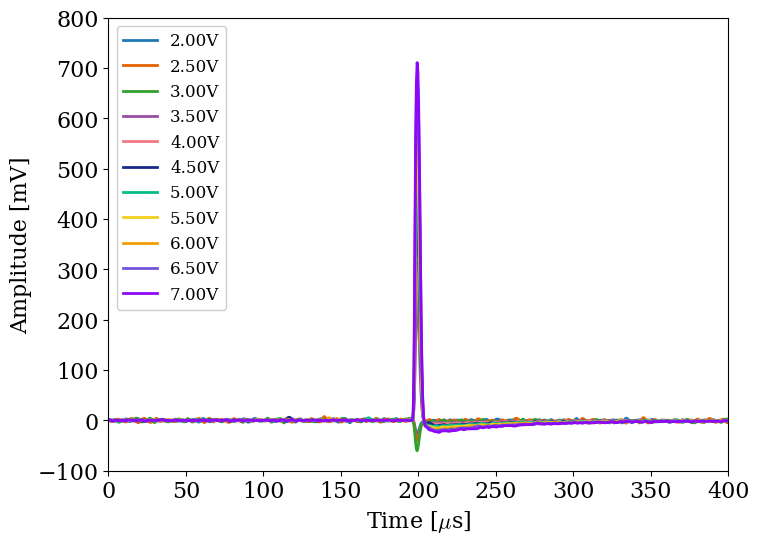

In [46]:
plt.figure() 
plt.xlim(0,400)
plt.xlabel('Time [$\mu$s]')
plt.ylabel('Amplitude [mV]')
for volt in voltages: 
    markers = ['o', 'x']
    for i,ch in enumerate(Ds[volt].Ch[1:]):
        plt.plot(ch.Time, np.mean(ch.Amp, axis=0), label='{}V'.format(volt))
plt.legend(loc='upper left', ncol=1)
plt.show() 

In [48]:
def gauss(x,a,mu,sigma):
    return (a*np.exp(-0.5*((x-mu)/sigma)**2))

In [49]:
def line_gain(x,m,c):
    return (m*x)+c

In [50]:
def gain_calculator(PATH):
    BINS=20 #Number of bins to rebin the MCA data with
    N_peaks= 4# Number o peaks to use for calculating the gain
    gain_list=[] #empty list to fill in the values of gain, returned at the end of this function
    gain_err=[] #empty list to fill in the values of gain fit error, returned at the end of this function
    Files = glob.glob(PATH+'mca_*.h5')
    #for loop to loop over all the files
    for i,file in enumerate(natsorted(Files)): 
        print(i,file)
        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys():
            df = np.array(ch2.get(key))
        h = df
        hx = np.arange(0,len(h),1)
        hx,h = rebin(hx,h, BINS)

        gain_temp=[]#reset the gain temp list here to store gain values for one file
        gain_temp_err=[]#reset the gain temp list here to store gain values for one file
        #Use scipy find_peaks to find peaks starting with a very high prominence 
        PROMINENCE=1000 #This prominence is re-set here to ensure that every file starts out with a high prominence
        peaks,pdict=find_peaks(h,prominence=PROMINENCE,width=50)
        peak_length=len(peaks)
        #We want to ensure that using a high prominence gives us at least 3 peaks to fit a straight line to. If it doesn't we reduce prominence till we get at least 3 peaks. N_peaks is set above
        while (peak_length<N_peaks+1):
            PROMINENCE=PROMINENCE-1
            peaks,pdict=find_peaks(h,prominence=PROMINENCE,width=10)
            peak_length=len(peaks)
        
        #To avoid fitting the pedestal, we ignore the first peak. In case the pedestal isn't there, then first peak gets ignored. This shouldn't change gain or BV calculation
        first_pe_max=hx[peaks[1]] # The x-value of the 2nd peak.Index=1 means the second peak will be used for getting fit parameters
        max_value=h[peaks[1]] # The height of the 2nd peak
        x_idx_array=(h<0.5*max_value) & (hx>first_pe_max)# returns a boolean array where both conditions are true
        right_side_x= hx[np.where(x_idx_array)[0][0]] #finding the first time where x_idx_array is True
        sigma_guess=np.abs(first_pe_max-right_side_x) #We need this to fit the width of the Gaussian peaks

        plt.figure(figsize=(12,5)) # Call the figure here
        plt.subplot(1,2,1) #This subplot will plot the position of the peaks and also the data
        plt.yscale('log')
        plt.plot(hx[peaks],h[peaks],'*') # plot the peak markers
        plt.step(hx,h,lw=1) #plot the signal
        cut= (hx < first_pe_max+sigma_guess) & (hx > first_pe_max-sigma_guess) # This cut helps to fix the width of the peak-fit
        popt,pcov=curve_fit(gauss,hx[cut],h[cut],p0=[max_value,first_pe_max,sigma_guess]) # We use curve_fit to return the optimal parameters and the covariance matrix
        plt.plot(hx[cut],gauss(hx[cut],*popt),color='green',label='Fit',lw=2,alpha=0.5) # Here we plot the fit on the 2nd peak to see if everything looks ok.
        for i,peak in enumerate(peaks[:]): #here we ignore the first peak because it could be the pedestal
            new_first_pe_max=hx[peak] #x-value of the peak
            new_max_value=h[peak] #height of the peak
            new_x_idx_array=(h<0.5*new_max_value) & (hx>new_first_pe_max) # returns a boolean array where both conditions are true
            new_right_side_x= hx[np.where(new_x_idx_array)[0][0]] #finding the first time where x_idx_array is True
            new_sigma_guess=np.abs(new_first_pe_max-new_right_side_x) #We need this to fit the width of the Gaussian peaks


            new_cut= (hx < new_first_pe_max+new_sigma_guess) & (hx > new_first_pe_max-new_sigma_guess) # This cut helps to fix the width of the peak-fit
            popt_new,pcov_new=curve_fit(gauss,hx[new_cut],h[new_cut],p0=[new_max_value,new_first_pe_max,new_sigma_guess],maxfev=100000) # We use curve_fit to return the optimal parameters and the covariance matrix
            plt.plot(hx[new_cut],gauss(hx[new_cut],*popt_new),color='r',label='Fit',lw=3) # Here we plot the fit on all the peaks
            gain_temp.append(popt_new[1]) #Here we append the value of the peak fit mean 
            perr = np.sqrt(np.diag(pcov_new))
            gain_temp_err.append(perr[1])
        print(gain_temp)
        print(np.diff(gain_temp))
        print(np.mean(np.diff(gain_temp)))

        plt.subplot(1,2,2) #This subplot shows the straight line fit to the peak means to obtain the slope/gain
        popt_temp,pcov_temp=curve_fit(line_gain,np.arange(0,len(peaks)),gain_temp,p0=[90,5],maxfev=10000) #Use the straight line fit here
        plt.plot(np.arange(0,len(peaks)),line_gain(np.arange(0,len(peaks)),*popt_temp),color='k',label=(str(np.round(popt_temp[0],2)))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_temp))[0],2))+' ADC/PE') # plot the straight line fit
        

        plt.errorbar(np.arange(0,len(peaks)),gain_temp, yerr=gain_temp_err, capsize=5, color='r', marker='o', ms=5, ls='None', label='Data') #plot the values of the peak means
        plt.legend(loc=2)
        plt.show() #show the plot
        gain_list.append(popt_temp[0]) #append the gain values to obtain BV later
        gain_err.append(np.sqrt(np.diag(pcov_temp))[0]) #append the straight line error fit 
    return(np.array(gain_list),np.array(gain_err))

0 C:\\Data\\20220609\mca_keith_2.00OV.h5
0 ' [  0 229 224 207 248 214 264 208 262 244]
[18.21086638140513, 65.18146133164583, 114.8740106589086, 164.75628004455513, 214.2462395735926]
[46.97059495 49.69254933 49.88226939 49.48995953]
49.00884329804686


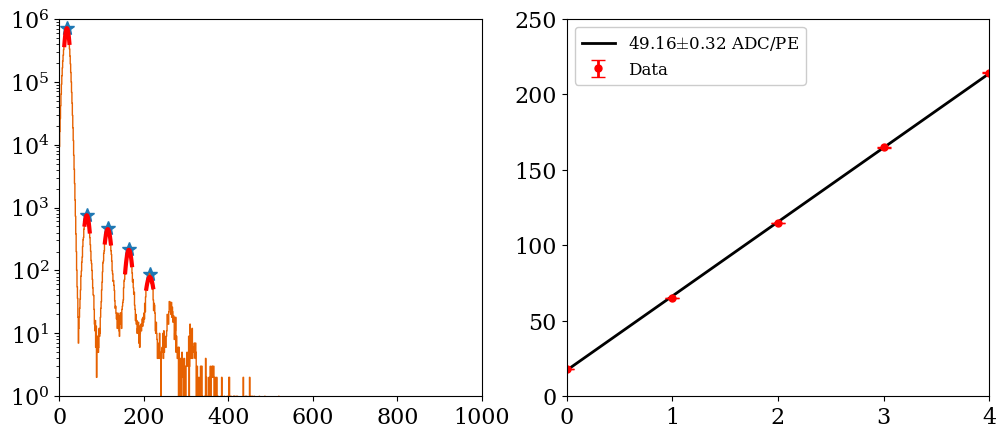

1 C:\\Data\\20220609\mca_keith_2.50OV.h5
0 ' [  0 246 249 252 253 224 235 251 260 253]
[18.091901865347094, 79.44612798734416, 143.16384858549475, 207.30558538114585, 271.8183397755945]
[61.35422612 63.7177206  64.1417368  64.51275439]
63.43160947756185


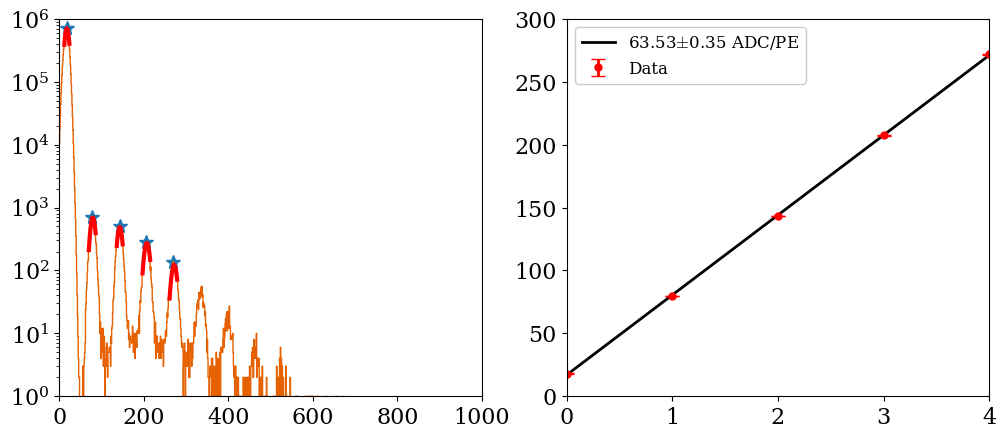

2 C:\\Data\\20220609\mca_keith_3.00OV.h5
0 ' [  0 367 303 307 342 311 331 347 363 346]
[17.957165660054233, 93.12677906553814, 171.7625359430762, 250.23401820637753, 328.64474166123694]
[75.16961341 78.63575688 78.47148226 78.41072345]
77.67189400029568


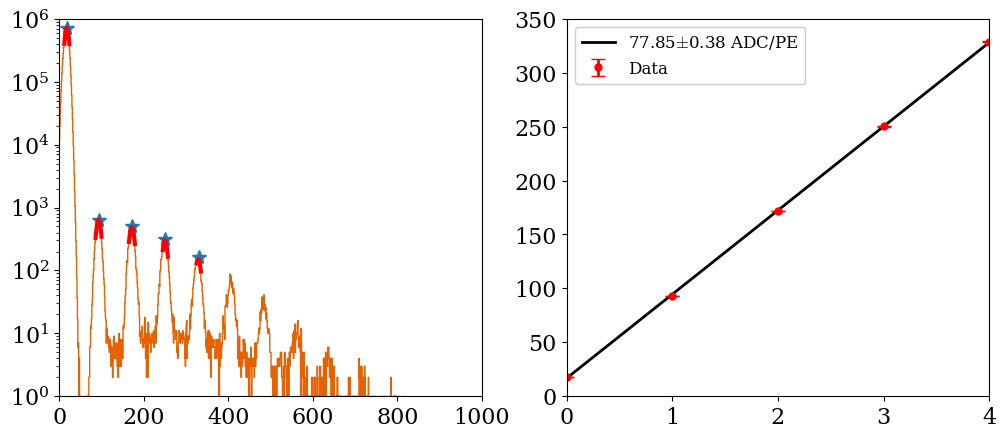

3 C:\\Data\\20220609\mca_keith_3.50OV.h5
0 ' [  1 522 437 430 433 470 440 442 457 513]
[17.78600912293493, 107.17730233077782, 199.44646092819343, 291.4212784221778, 383.4404637745696]
[89.39129321 92.2691586  91.97481749 92.01918535]
91.41361366290866


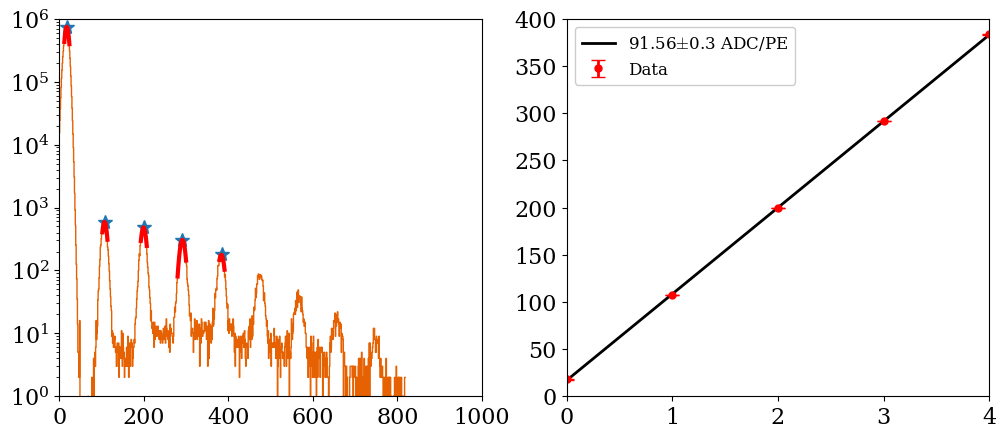

4 C:\\Data\\20220609\mca_keith_4.00OV.h5
0 ' [  1 734 617 597 616 553 602 646 588 602]
[17.629512079889658, 120.70738594225804, 226.7173588880428, 332.4129790879121, 438.2929322399371]
[103.07787386 106.00997295 105.6956202  105.87995315]
105.16585504001186


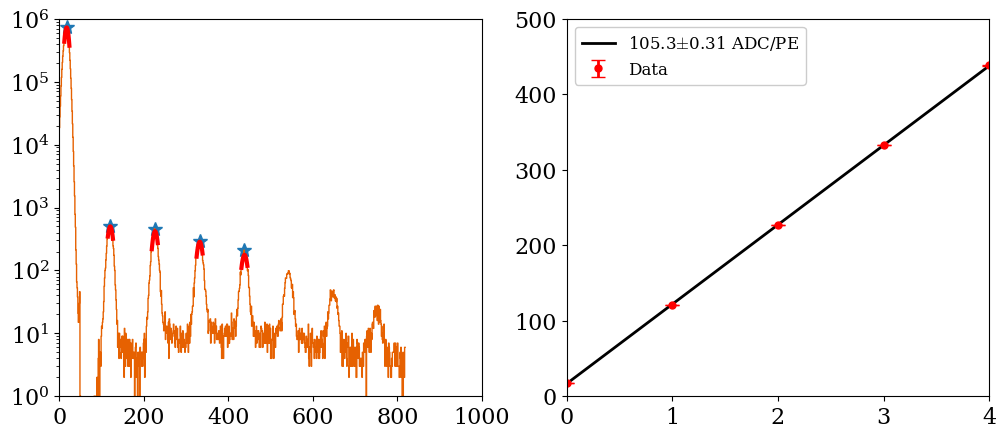

5 C:\\Data\\20220609\mca_keith_4.50OV.h5
0 ' [  0 950 759 784 731 732 826 789 798 788]
[17.527810375749127, 134.0514204792527, 253.8594548833275, 372.97875596515195, 491.8090987059302]
[116.5236101  119.8080344  119.11930108 118.83034274]
118.57032208254526


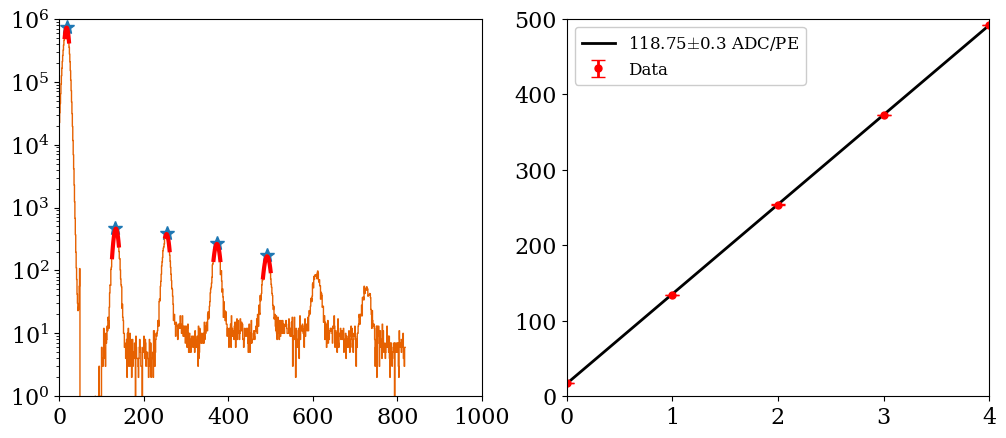

6 C:\\Data\\20220609\mca_keith_5.00OV.h5
0 ' [   1 1226  976  991  931  970  999 1011 1002 1070]
[17.337380246419208, 147.13949404069646, 279.664509202445, 411.56015449199447, 543.3892930197694]
[129.80211379 132.52501516 131.89564529 131.82913853]
131.51297819333757


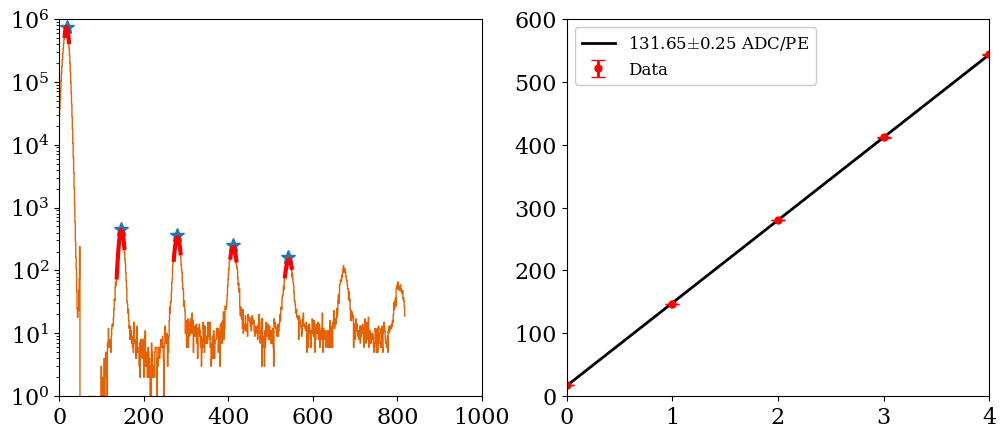

7 C:\\Data\\20220609\mca_keith_5.50OV.h5
0 ' [   0 1517 1179 1238 1209 1261 1207 1233 1256 1209]
[17.073762992464708, 159.98780875377616, 304.8881367892589, 450.12112699521066, 594.1774029408039]
[142.91404576 144.90032804 145.23299021 144.05627595]
144.2759099870848


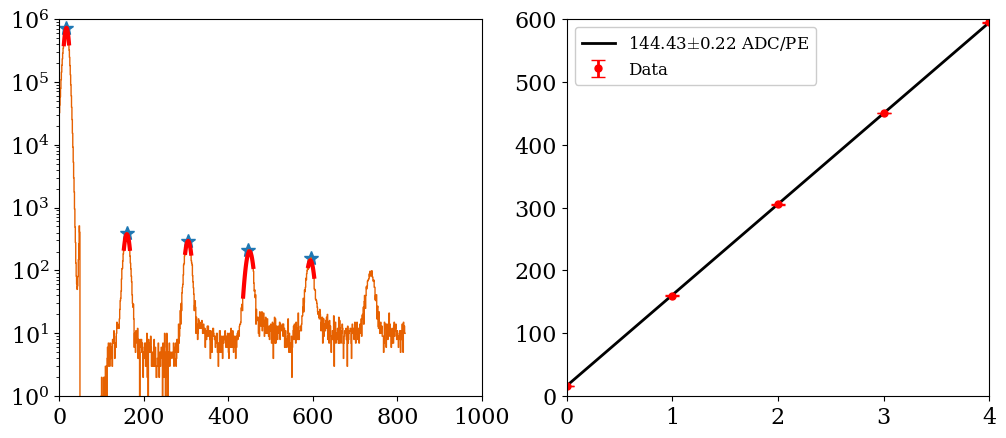

8 C:\\Data\\20220609\mca_keith_6.00OV.h5
0 ' [   1 1816 1477 1435 1417 1465 1455 1532 1459 1521]
[16.848782200070723, 171.54109520232595, 329.5034371537725, 486.28006444740305, 642.1906778449927]
[154.692313   157.96234195 156.77662729 155.9106134 ]
156.3354739112305


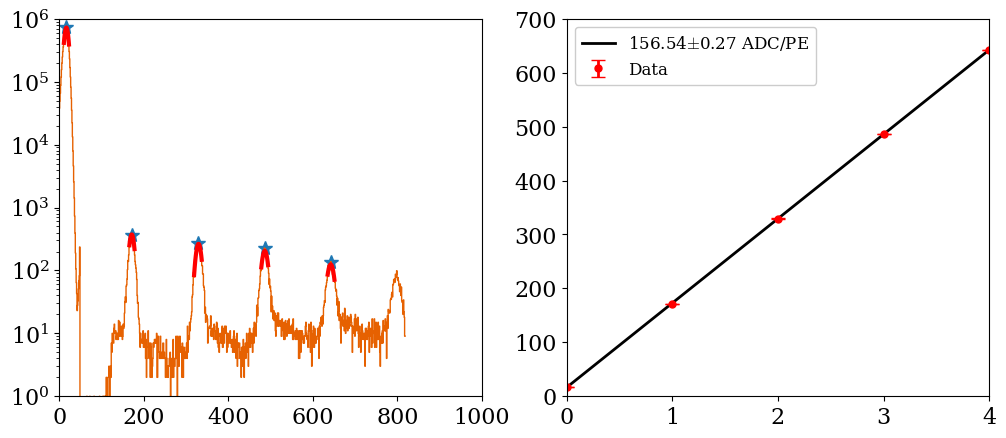

9 C:\\Data\\20220609\mca_keith_6.50OV.h5
0 ' [   0 2121 1741 1729 1732 1713 1751 1760 1771 1754]
[16.652570785385752, 183.5969893081587, 352.8937628517588, 521.9235162038343, 689.3914166274942]
[166.94441852 169.29677354 169.02975335 167.46790042]
168.18471146052713


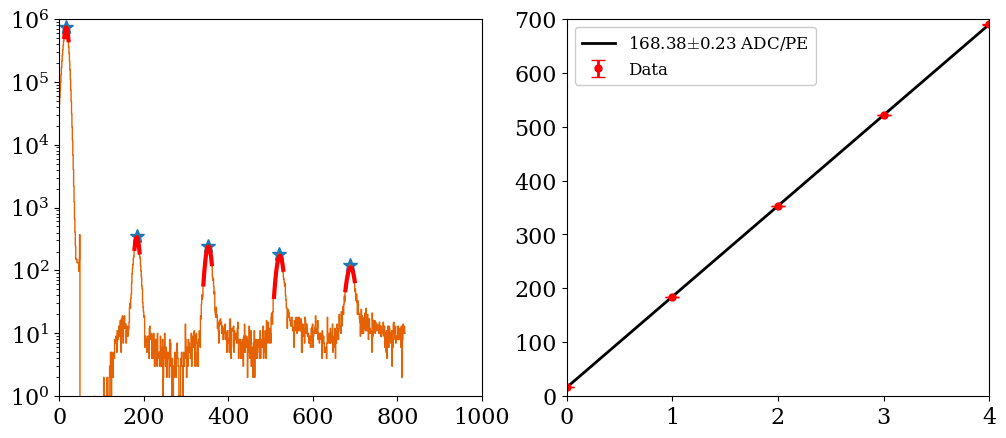

10 C:\\Data\\20220609\mca_keith_7.00OV.h5
0 ' [   1 2496 2023 2064 1981 2023 2097 2030 2051 2171]
[16.35577096655004, 195.01968531648052, 375.59768602040987, 555.7169082177237, 734.1686572118857]
[178.66391435 180.5780007  180.1192222  178.45174899]
179.45322156133392


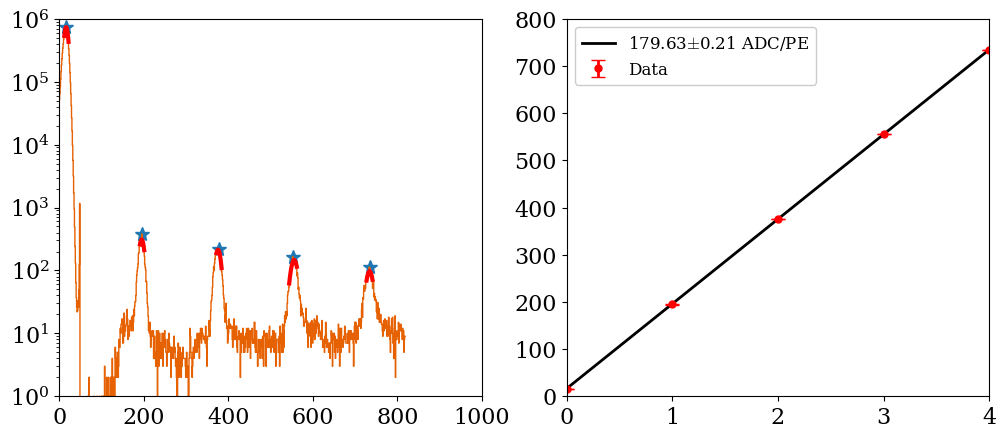

In [51]:
gain_list_0V,gain_err_0V=gain_calculator(Path)

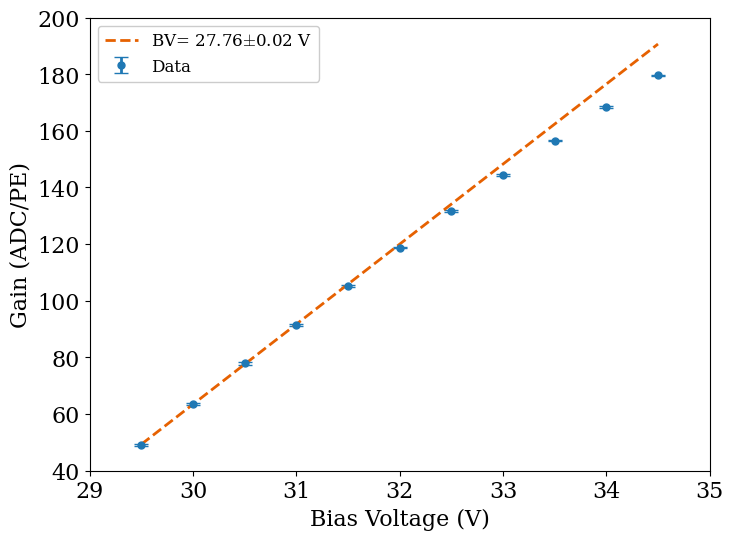

In [52]:
def line(x,a,b):
    return a*(x-b)

volts = voltages.astype(float) + 27.5
x_data=np.arange(np.min(volts),np.max(volts)+0.1,1)
plt.errorbar(volts,gain_list_0V,yerr=gain_err_0V,label='Data',fmt='o',ms=5)

popt_0,pcov_0=curve_fit(line,volts[:4],gain_list_0V[:4],p0=[31,27],sigma=gain_err_0V[:4])
label = 'BV= '+str(np.round(popt_0[1],2))+ '$\pm$'+ str(np.round(np.sqrt(np.diag(pcov_0)[1]),2))+' V'
plt.plot(x_data, line(x_data,*popt_0), color=colors[1], ls='--', label=label)
# plt.plot(x_data,line(x_data,*popt_260),color=colors[1],label='BV= '+str(np.round(popt_260[1],2))+ '$\pm$'+ str(np.round(np.sqrt(np.diag(pcov_260)[1]),2))+' V',ls='--')
plt.ylabel('Gain (ADC/PE)')
plt.xlabel('Bias Voltage (V)')
plt.legend(loc=2)
plt.savefig('BV_comparison.pdf')
plt.show()

In [53]:
print (voltages)

['2.00' '2.50' '3.00' '3.50' '4.00' '4.50' '5.00' '5.50' '6.00' '6.50'
 '7.00']
